In [3]:
# !pip install pgmpy
# !pip install sweetviz
# !pip install pandas-profiling

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from pgmpy.models import BayesianNetwork
from pgmpy.factors.discrete import TabularCPD
from pgmpy.inference import VariableElimination

from pgmpy.estimators import HillClimbSearch, BicScore
from pgmpy.estimators import PC

import networkx as nx
import sweetviz as sv
from ydata_profiling import ProfileReport

from scipy.stats import chi2_contingency

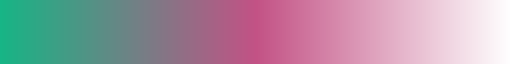

In [5]:
from matplotlib.colors import LinearSegmentedColormap

## paleta de colores
pink= "#C35285"
green = "#17B586"
colors = [green, pink, "white"]

# Crea un mapa de colores personalizado
cmap = LinearSegmentedColormap.from_list("my_cmap", colors, N=256)
cmap

# Lectura de Datos

In [6]:
df_mental = pd.read_csv("mental_health_finaldata_1.csv")
print(df_mental.shape)
df_mental.head()

(824, 13)


,Age,Gender,Occupation,Days_Indoors,Growing_Stress,Quarantine_Frustrations,Changes_Habits,Mental_Health_History,Weight_Change,Mood_Swings,Coping_Struggles,Work_Interest,Social_Weakness
0,20-25,Female,Corporate,1-14 days,Yes,Yes,No,Yes,Yes,Medium,No,No,Yes
1,30-Above,Male,Others,31-60 days,Yes,Yes,Maybe,No,No,High,No,No,Yes
2,30-Above,Female,Student,Go out Every day,No,No,Yes,No,No,Medium,Yes,Maybe,No
3,25-30,Male,Others,1-14 days,Yes,No,Maybe,No,Maybe,Medium,No,Maybe,Yes
4,16-20,Female,Student,More than 2 months,Yes,Yes,Yes,No,Yes,Medium,Yes,Maybe,No


In [7]:
df_mental.isna().sum()

Age                        0
Gender                     0
Occupation                 0
Days_Indoors               0
Growing_Stress             0
Quarantine_Frustrations    0
Changes_Habits             0
Mental_Health_History      0
Weight_Change              0
Mood_Swings                0
Coping_Struggles           0
Work_Interest              0
Social_Weakness            0
dtype: int64

In [8]:
df_mental.describe().T

,count,unique,top,freq
Age,824,4,30-Above,222
Gender,824,2,Female,434
Occupation,824,5,Housewife,185
Days_Indoors,824,5,31-60 days,171
Growing_Stress,824,3,Yes,301
Quarantine_Frustrations,824,3,Yes,304
Changes_Habits,824,3,Yes,305
Mental_Health_History,824,3,No,284
Weight_Change,824,3,Maybe,281
Mood_Swings,824,3,Medium,280


In [9]:
df_mental.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 824 entries, 0 to 823
Data columns (total 13 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   Age                      824 non-null    object
 1   Gender                   824 non-null    object
 2   Occupation               824 non-null    object
 3   Days_Indoors             824 non-null    object
 4   Growing_Stress           824 non-null    object
 5   Quarantine_Frustrations  824 non-null    object
 6   Changes_Habits           824 non-null    object
 7   Mental_Health_History    824 non-null    object
 8   Weight_Change            824 non-null    object
 9   Mood_Swings              824 non-null    object
 10  Coping_Struggles         824 non-null    object
 11  Work_Interest            824 non-null    object
 12  Social_Weakness          824 non-null    object
dtypes: object(13)
memory usage: 83.8+ KB


# EDA

## AutoEDA

In [ ]:
# profile = ProfileReport(df_mental, title='Perfilado de Datos', explorative=True)
# profile

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

                                             |          | [  0%]   00:00 -> (? left)


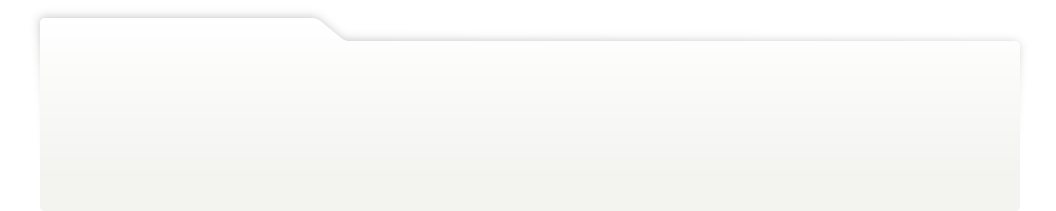
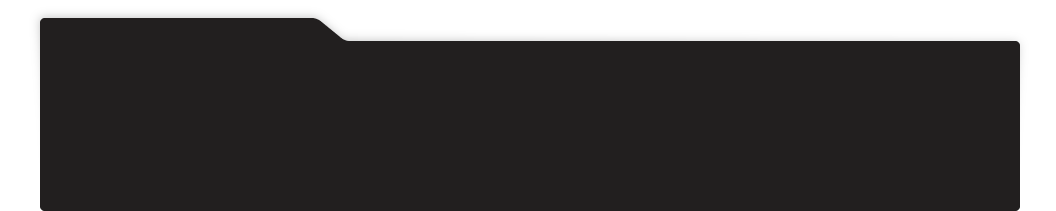
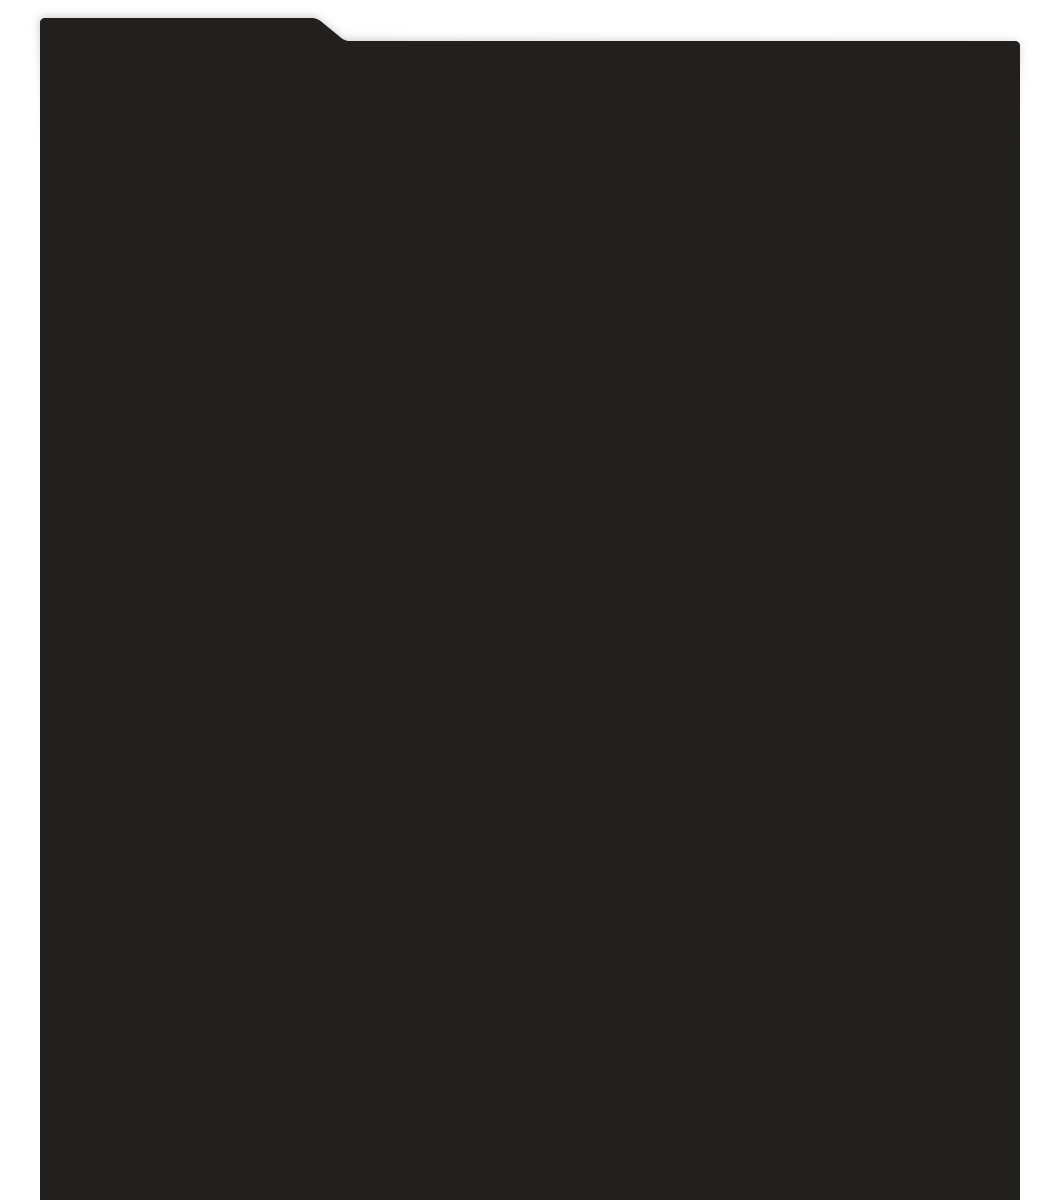
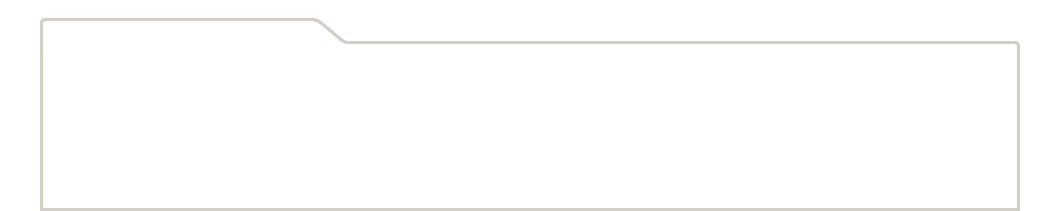
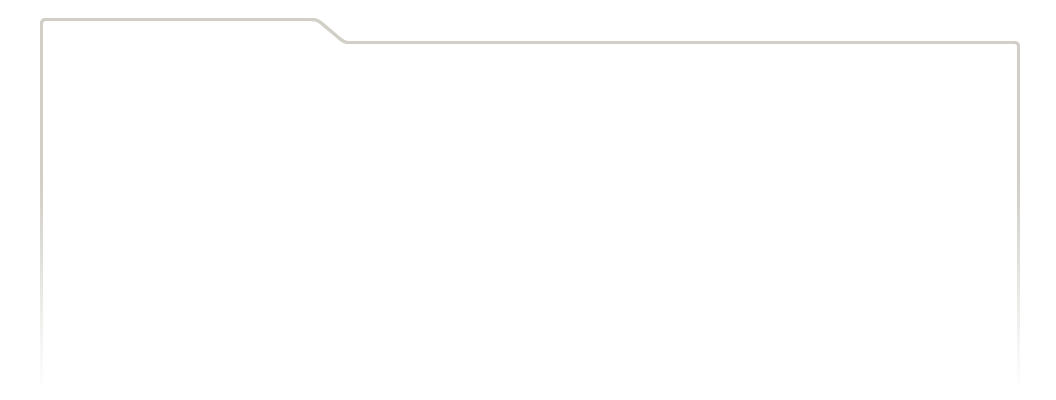
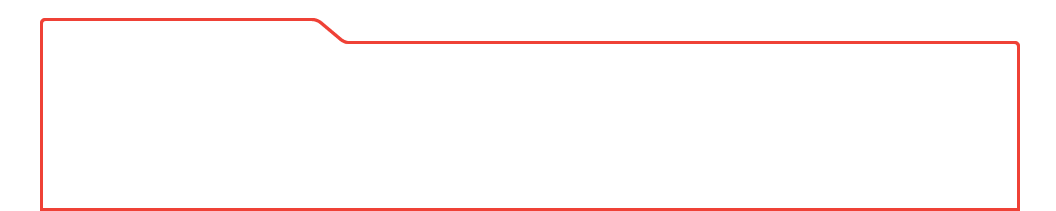
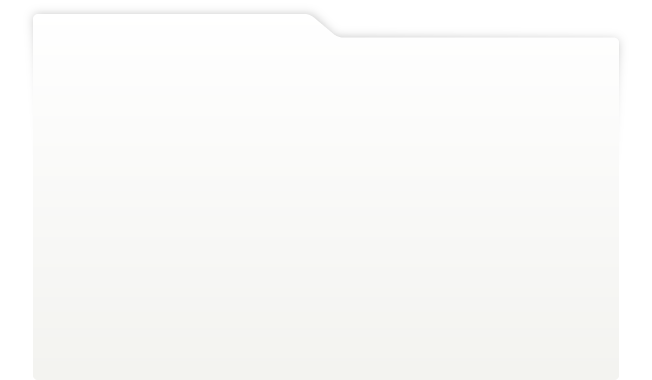
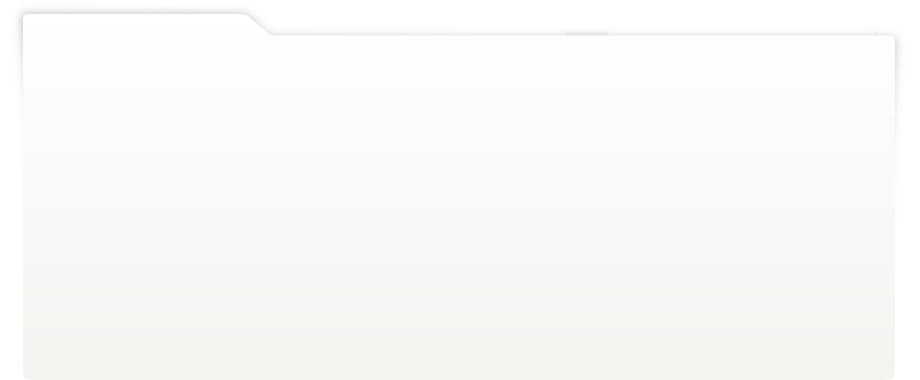
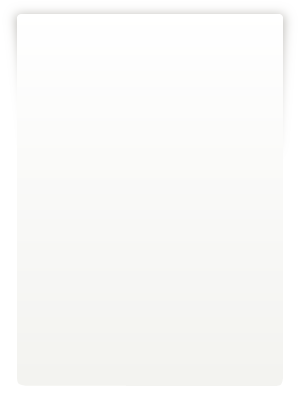
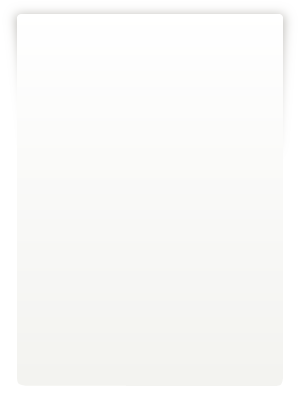
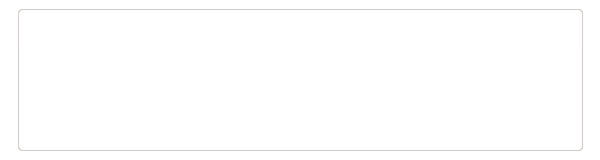
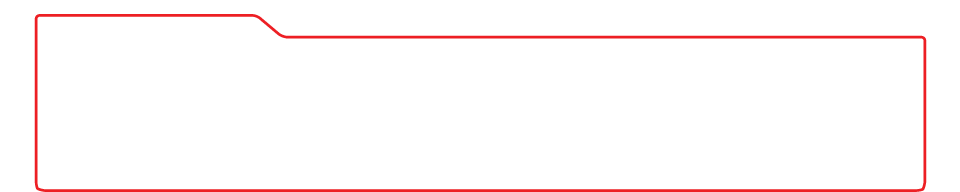
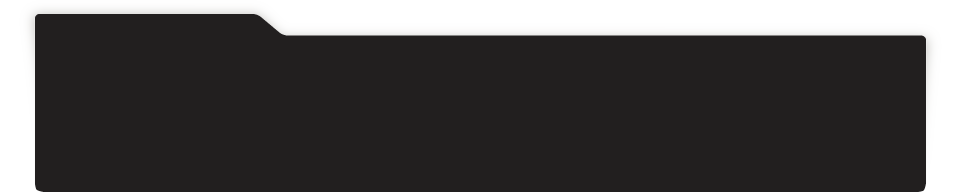
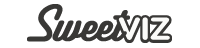
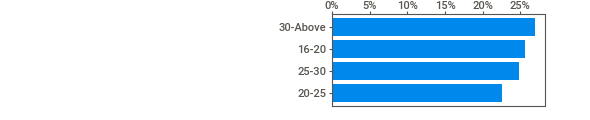
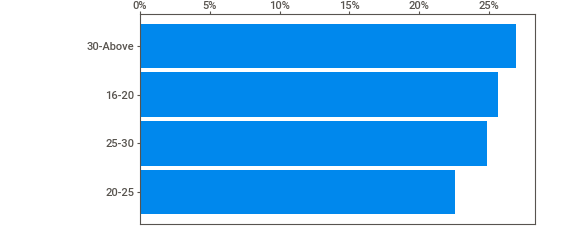
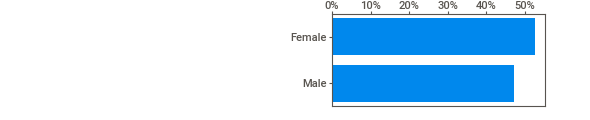
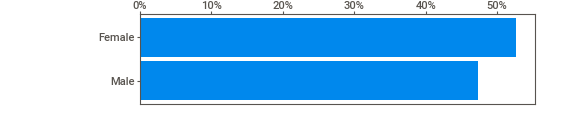
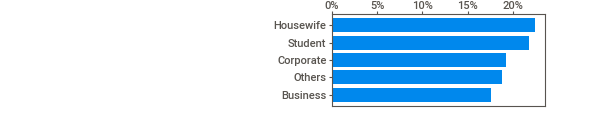
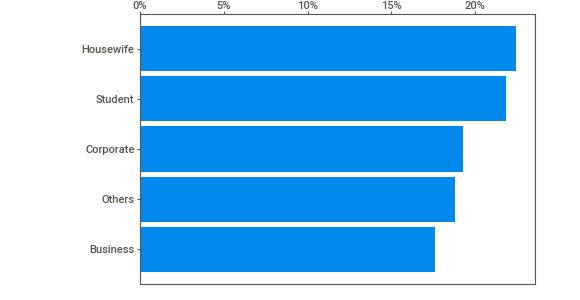
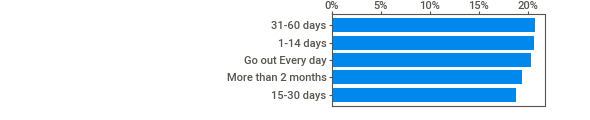
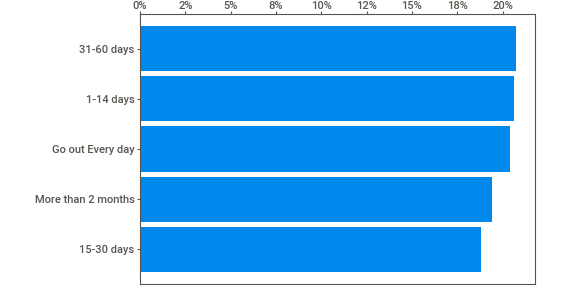
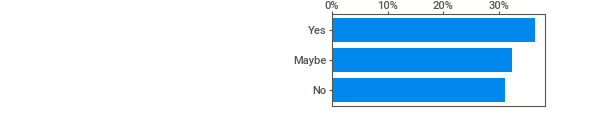
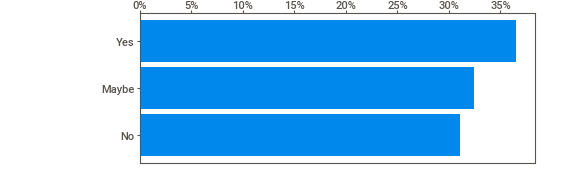
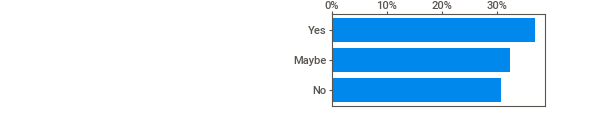
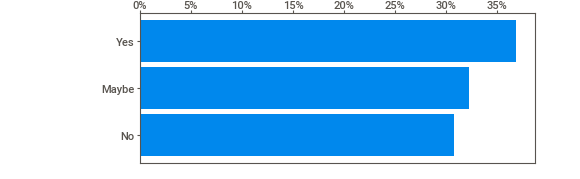
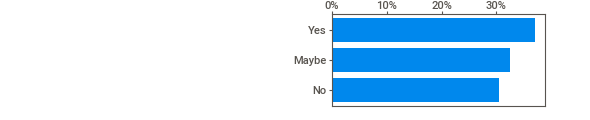
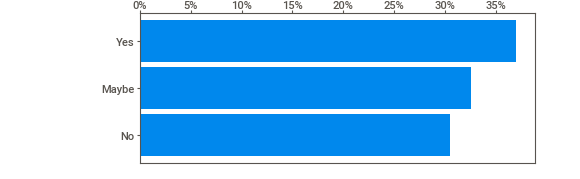
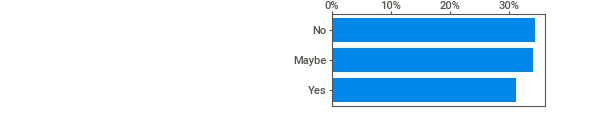
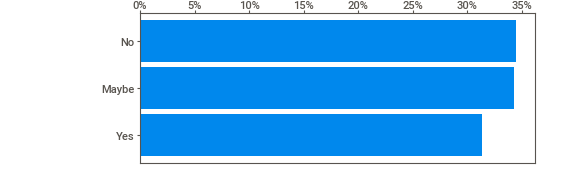
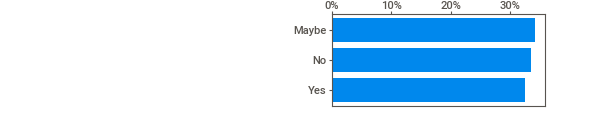
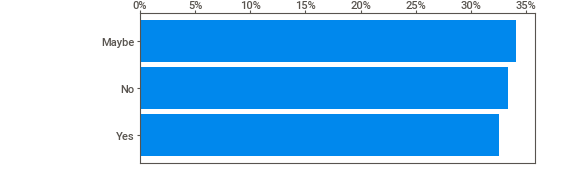
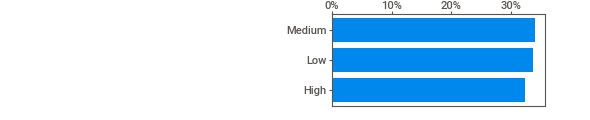
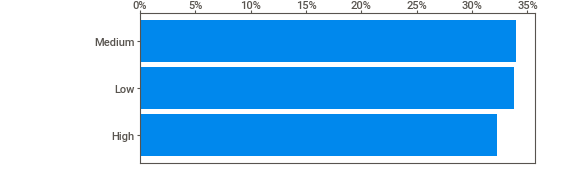
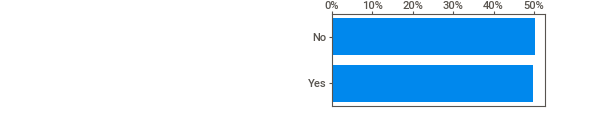
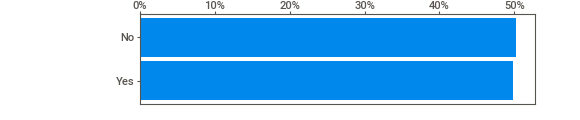
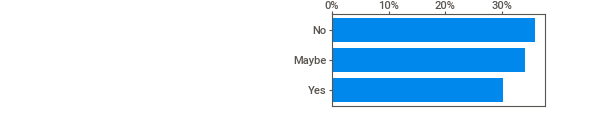
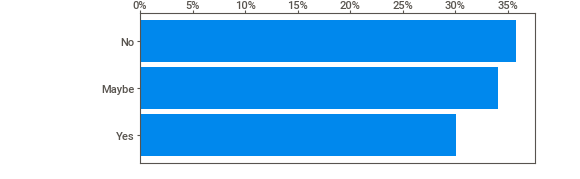
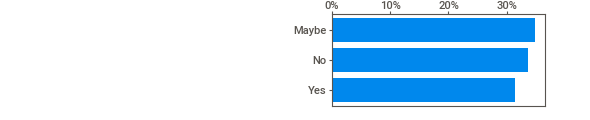
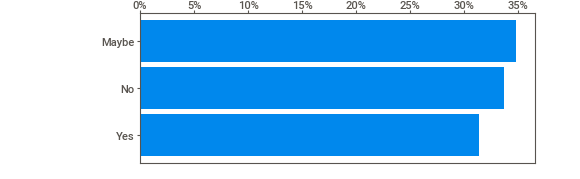
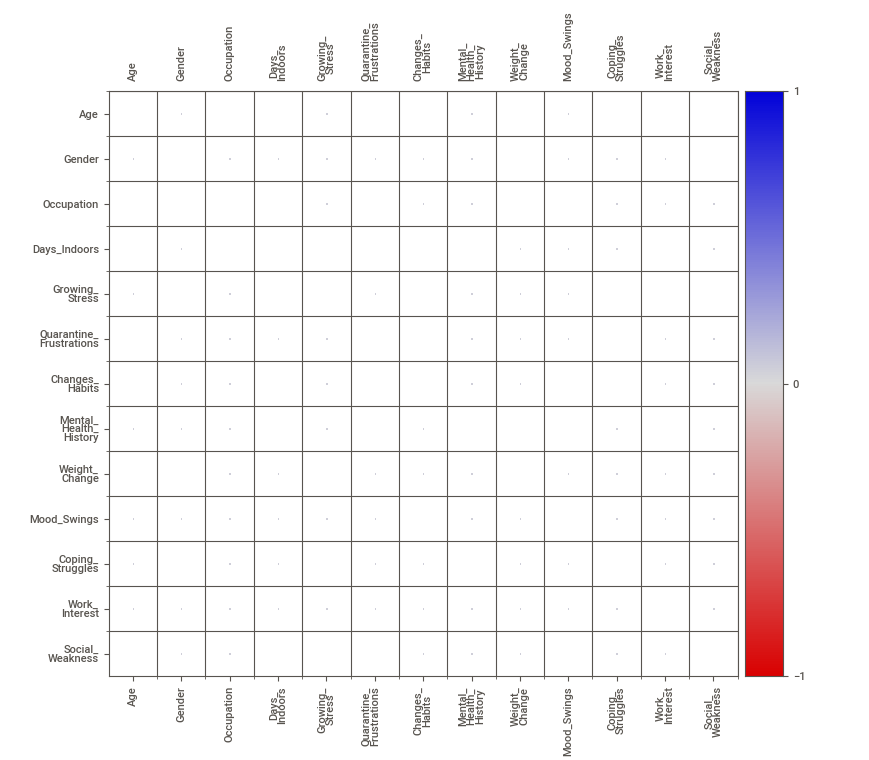
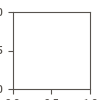

In [ ]:
# sv_mental = sv.analyze(df_mental, )
# sv_mental.show_notebook()

## Correlación de variables

* **Hipótesis Nula (H0):** La hipótesis nula afirma que no hay asociación entre las dos variables
* **Hipótesis Alternativa (H1):** La hipótesis alternativa afirma que hay una asociación entre las dos variables.

### Interpreación del p-value

**p-valor bajo (< 0.05 generalmente):** Si el p-valor es menor que el nivel de significancia (usualmente 0.05), se rechaza la hipótesis nula. Esto sugiere que hay suficiente evidencia en los datos para afirmar que existe una asociación significativa entre las variables.

**p-valor alto (≥ 0.05):** Si el p-valor es igual o mayor que el nivel de significancia, no se rechaza la hipótesis nula. Esto indica que no hay suficiente evidencia para afirmar que existe una asociación entre las variables, o dicho de otra forma, las diferencias observadas podrían deberse al azar.

In [10]:
table = pd.crosstab(df_mental["Age"], df_mental["Weight_Change"])

## get the chi2
chi2, p, dof, expected = chi2_contingency(table)
print(f"Chi-cuadrado: {chi2}, p-valor: {p}, grados de libertad: {dof}")

table

Chi-cuadrado: 9.699767718698466, p-valor: 0.13787820772326292, grados de libertad: 6


Weight_Change,Maybe,No,Yes
Age,,,
16-20,68,80,63
20-25,54,72,60
25-30,73,62,70
30-Above,86,61,75


In [11]:
cols = df_mental.columns
n_columns = len(cols)

p_values = pd.DataFrame(np.ones((n_columns, n_columns)), index=df_mental.columns, columns=df_mental.columns)

for i in cols:
    for j in cols:
        table = pd.crosstab(df_mental[i], df_mental[j])
        chi2, p, dof, expected = chi2_contingency(table)
        p_values.loc[i, j] = round(p, 4)

p_values

,Age,Gender,Occupation,Days_Indoors,Growing_Stress,Quarantine_Frustrations,Changes_Habits,Mental_Health_History,Weight_Change,Mood_Swings,Coping_Struggles,Work_Interest,Social_Weakness
Age,0.0000,0.6240,0.2267,0.0648,0.3693,0.2854,0.3361,0.7734,0.1379,0.8244,0.9849,0.4438,0.0383
Gender,0.6240,0.0000,0.4754,0.8478,0.0946,0.9490,0.8970,0.3646,0.0544,0.6763,0.0423,0.7141,0.8865
Occupation,0.2267,0.4754,0.0000,0.1452,0.9863,0.4221,0.8996,0.6344,0.0672,0.1950,0.2909,0.7941,0.9513
Days_Indoors,0.0648,0.8478,0.1452,0.0000,0.2025,0.6553,0.3878,0.2233,0.8009,0.8920,0.3848,0.6071,0.4301
Growing_Stress,0.3693,0.0946,0.9863,0.2025,0.0000,0.3132,0.0500,0.7720,0.8865,0.2911,0.9929,0.1571,0.9040
Quarantine_Frustrations,0.2854,0.9490,0.4221,0.6553,0.3132,0.0000,0.1142,0.0983,0.6372,0.9421,0.9363,0.7649,0.0586
Changes_Habits,0.3361,0.8970,0.8996,0.3878,0.0500,0.1142,0.0000,0.2967,0.5320,0.1318,0.8290,0.3730,0.8681
Mental_Health_History,0.7734,0.3646,0.6344,0.2233,0.7720,0.0983,0.2967,0.0000,0.2266,0.1790,0.5555,0.0799,0.5576
Weight_Change,0.1379,0.0544,0.0672,0.8009,0.8865,0.6372,0.5320,0.2266,0.0000,0.3973,0.4618,0.7014,0.5864
Mood_Swings,0.8244,0.6763,0.1950,0.8920,0.2911,0.9421,0.1318,0.1790,0.3973,0.0000,0.2846,0.4282,0.2348


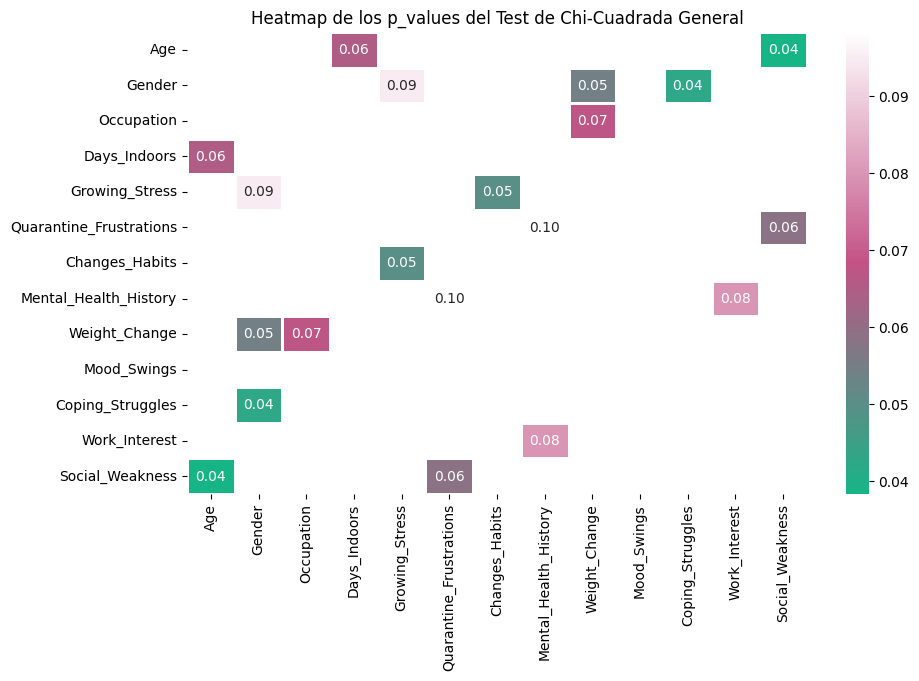

In [12]:
## heatmap de los p-values
plt.figure(figsize=(10, 6))

p_values_filter = p_values[p_values.abs() < 0.1].copy()
np.fill_diagonal(p_values_filter.values, np.nan)

#mask = np.triu(p_values_filter)

sns.heatmap(p_values_filter, annot=True, fmt=".2f", linecolor="w", linewidths=1, cmap=cmap)
plt.title("Heatmap de los p_values del Test de Chi-Cuadrada General")
plt.show()

# Representación del Modelo DAG

## Modelo basado en restricciones

In [13]:
pc = PC(df_mental)
model_pc = pc.estimate()

print("Edges del Modelo PC:", model_pc.edges())

  0%|          | 0/5 [00:00<?, ?it/s]

Edges del Modelo PC: []


## Modelo basado en Restricciones y Puntuaciones

In [14]:
hc = HillClimbSearch(df_mental)
best_model = hc.estimate(BicScore(df_mental))
print("Edges del Modelo Estimado:", best_model.edges())

  0%|          | 0/1000000 [00:00<?, ?it/s]

Edges del Modelo Estimado: []


# Pruebas para diferentes muestras

In [15]:
def get_dag(df):
    cols = df.columns
    n_columns = len(cols)

    ## pruebas de independencia
    p_values = pd.DataFrame(np.ones((n_columns, n_columns)), index=df.columns, columns=df.columns)

    for i in cols:
        for j in cols:
            table = pd.crosstab(df[i], df[j])
            chi2, p, dof, expected = chi2_contingency(table)
            p_values.loc[i, j] = round(p, 4)


    plt.figure(figsize=(10, 6))

    p_values_filter = p_values[p_values.abs() < 0.1].copy()
    np.fill_diagonal(p_values_filter.values, np.nan)

    ## ploteo del heatmap
    sns.heatmap(p_values_filter, annot=True, fmt=".2f", linecolor="w", linewidths=1, cmap=cmap)
    plt.title("Heatmap de los p_values del Test de Chi-Cuadrada")
    plt.show()

    ## obtención del DAG
    pc = PC(df)
    model_pc = pc.estimate()

    print("Edges del Modelo PC:", model_pc.edges())

    hc = HillClimbSearch(df)
    best_model = hc.estimate(BicScore(df))
    print("Edges del Modelo Estimado:", best_model.edges())

(434, 13)


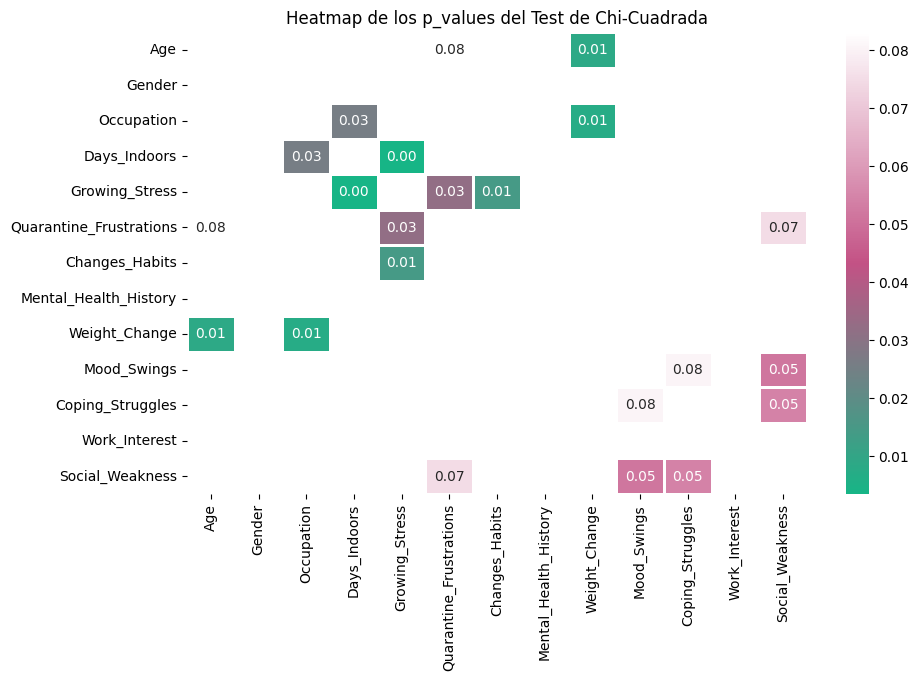

  0%|          | 0/5 [00:00<?, ?it/s]

Edges del Modelo PC: [('Occupation', 'Weight_Change'), ('Age', 'Weight_Change'), ('Growing_Stress', 'Days_Indoors')]


  0%|          | 0/1000000 [00:00<?, ?it/s]

Edges del Modelo Estimado: []


In [21]:
df = df_mental[df_mental["Gender"]=="Female"].copy()
print(df.shape)
get_dag(df)

(211, 13)


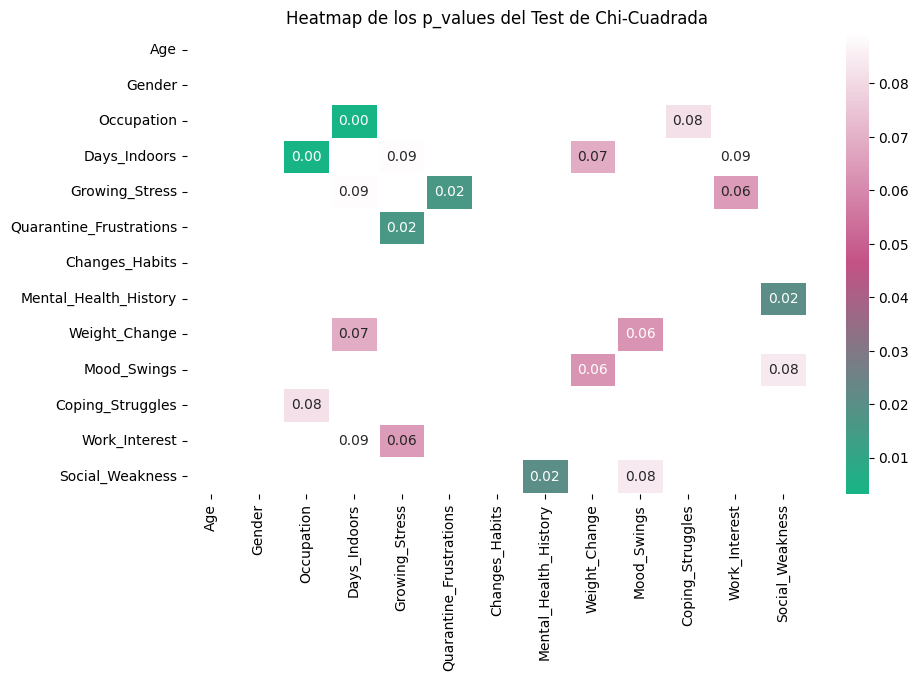

  0%|          | 0/5 [00:00<?, ?it/s]

Edges del Modelo PC: [('Days_Indoors', 'Occupation')]


  0%|          | 0/1000000 [00:00<?, ?it/s]

Edges del Modelo Estimado: [('Quarantine_Frustrations', 'Growing_Stress')]


In [27]:
df = df_mental[(df_mental["Gender"]=="Female") & (df_mental["Growing_Stress"]!="Maybe") & (df_mental["Quarantine_Frustrations"]!="Maybe")].copy()
print(df.shape)
get_dag(df)

# Análisis PGM

## Selección de Datos

In [28]:
cols = ['Age', 'Gender', 'Occupation', 'Days_Indoors', 'Growing_Stress',
       'Quarantine_Frustrations', 'Changes_Habits', 'Mental_Health_History',
       'Weight_Change', 'Mood_Swings', 'Social_Weakness']

df_final = df_mental[(df_mental["Gender"]=="Female") & (df_mental["Growing_Stress"]!="Maybe") & (df_mental["Quarantine_Frustrations"]!="Maybe")].copy()
df_final = df_final[cols].copy()
print(df_final.shape)
df_final.head()

(211, 11)


,Age,Gender,Occupation,Days_Indoors,Growing_Stress,Quarantine_Frustrations,Changes_Habits,Mental_Health_History,Weight_Change,Mood_Swings,Social_Weakness
0,20-25,Female,Corporate,1-14 days,Yes,Yes,No,Yes,Yes,Medium,Yes
2,30-Above,Female,Student,Go out Every day,No,No,Yes,No,No,Medium,No
4,16-20,Female,Student,More than 2 months,Yes,Yes,Yes,No,Yes,Medium,No
6,16-20,Female,Business,Go out Every day,Yes,Yes,Maybe,No,Yes,Low,Maybe
7,25-30,Female,Student,1-14 days,Yes,No,Maybe,Maybe,Maybe,High,Yes


In [29]:
df_final.describe().T

,count,unique,top,freq
Age,211,4,25-30,63
Gender,211,1,Female,211
Occupation,211,5,Student,49
Days_Indoors,211,5,1-14 days,48
Growing_Stress,211,2,Yes,123
Quarantine_Frustrations,211,2,Yes,120
Changes_Habits,211,3,Maybe,78
Mental_Health_History,211,3,Maybe,83
Weight_Change,211,3,No,77
Mood_Swings,211,3,High,79


In [31]:
df_mental.describe().T

,count,unique,top,freq
Age,824,4,30-Above,222
Gender,824,2,Female,434
Occupation,824,5,Housewife,185
Days_Indoors,824,5,31-60 days,171
Growing_Stress,824,3,Yes,301
Quarantine_Frustrations,824,3,Yes,304
Changes_Habits,824,3,Yes,305
Mental_Health_History,824,3,No,284
Weight_Change,824,3,Maybe,281
Mood_Swings,824,3,Medium,280


## Tablas de Frecuencias

In [32]:
pd.crosstab(df_final["Quarantine_Frustrations"], df_final["Days_Indoors"])

Days_Indoors,1-14 days,15-30 days,31-60 days,Go out Every day,More than 2 months
Quarantine_Frustrations,,,,,
No,16,18,20,19,18
Yes,32,22,20,26,20
